## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import pyplot

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation, partitions
from functions import unscaler, k_folds_indexs, model_fitting_kfold, weighting_models, jsontotable, plot_results, reconstructing_data, my_calibration_plot

In [5]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
['var_4', 'var_12', 'var_46', 'var_78', 'var_81', 'var_110', 'var_152', 'var_175', 'var_183', 'var_199']
numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81']

<b> random split

In [8]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [9]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [10]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
train_dataset_scaled, scalerx = scaler(train_dataset_distance)

<b> validation_dataset is ussed as the test set

<b> sectioning:

In [11]:
train_section_1, train_section_2, train_section_3 = partitions(train_dataset_scaled)

### Cross validation using K-fold and parameter tunning

### Section 1

In [12]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
Name: mahalanobis, dtype: int64

In [13]:
dict_1 = {'n':7600, 'range': [15,40], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':5000, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':9000, 'range': [15,40], 'label': 4, 'category': 2} # augmetation on the previous random ones

unscld_train_section_1 =unscaler(train_section_1, scalerx)
train_section_1_aug = augmentation_strategy(data = unscld_train_section_1, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_1
train_section_1_aug =  scaler(train_section_1_aug,scalerx)

In [14]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
2     7600
3     5000
4     9000
Name: mahalanobis, dtype: int64

### Model Exploration

### Common data to train and validation

In [15]:
seed = 158
validation_dataset_section1 = train_section_1_aug[train_section_1_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section1 = validation_dataset_section1.copy()
train_dataset_section1 = train_section_1_aug[~train_section_1_aug.index.isin(validation_dataset_section1.index)]

In [16]:
train_dataset_section1_aug = augmentation_selection_rates(train_dataset_section1, rate = 1.0, sample = 0.7)

In [17]:
validation_dataset_section1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    3600
1     652
Name: mahalanobis, dtype: int64

In [18]:
validation_dataset_section1_balanced =  balance_validation(validation_dataset_section1, 500)

In [19]:
validation_dataset_section1_balanced.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    1152
1     652
Name: mahalanobis, dtype: int64

In [20]:
X_train = train_dataset_section1_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section1_aug['target']

X_val = validation_dataset_section1_balanced[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section1_balanced['target']

#### Support Vector Machine

In [21]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.35, probability = True)
my_svm.fit(X_train, Y_train)

SVC(gamma=0.35, probability=True)

In [22]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [23]:
svm_metrics

{'Train': {'precision': 0.9241488103062968,
  'Accuracy': 0.8516070017878674,
  'AUC': 0.9215914844897953},
 'Validation': {'precision': 0.5448979591836735,
  'Accuracy': 0.6629711751662971,
  'AUC': 0.6707060540218133}}

In [24]:
conf_mat

Pred,0,1
True,,
0,929,223
1,385,267


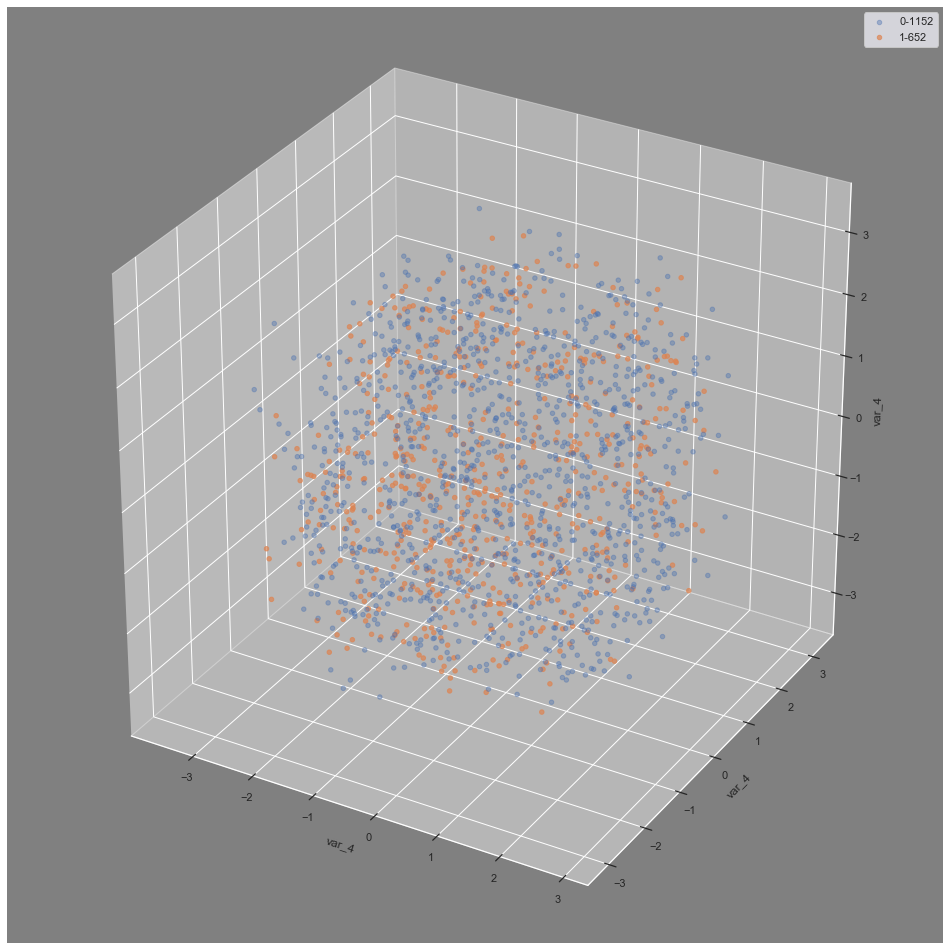

In [25]:
threeD_plot(validation_dataset_section1_balanced,['var_4', 'var_12', 'var_46'], fraq = 1.00)

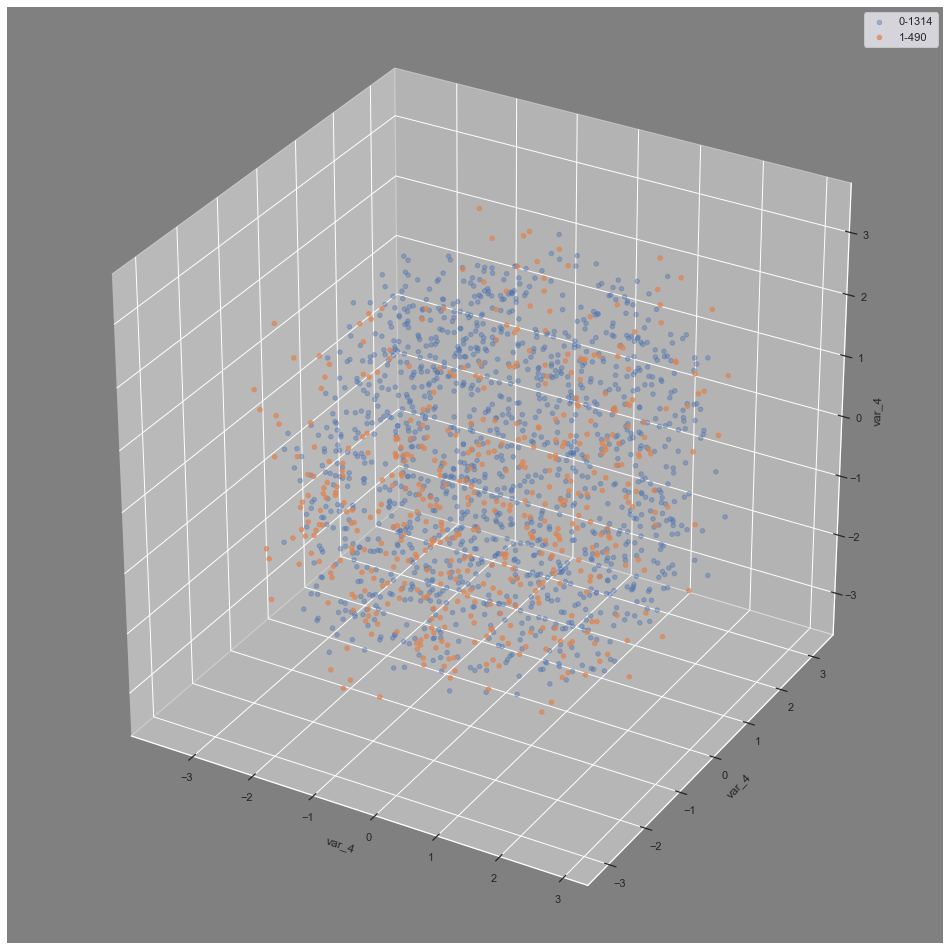

In [26]:
validation_set_pred = validation_dataset_section1_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

<b> Calibration

In [27]:
calibrated_svm = CalibratedClassifierCV(my_svm, method='isotonic', cv=5)
calibrated_svm.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=SVC(gamma=0.35, probability=True), cv=5,
                       method='isotonic')

In [28]:
svm_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_svm, X_train, Y_train, X_val, Y_val)

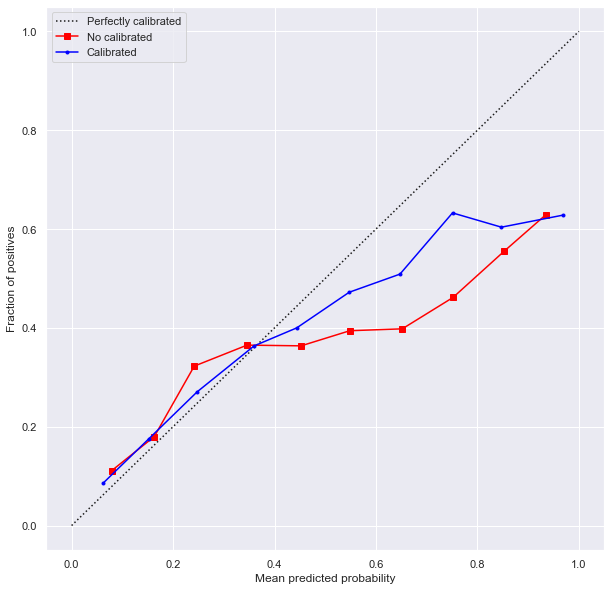

In [29]:
my_calibration_plot(model = my_svm, calibrated_model = calibrated_svm, X_data = X_val, Y_data = Y_val)

### KNN

In [30]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

In [31]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [32]:
knn_metrics

{'Train': {'precision': 0.9469285937012785,
  'Accuracy': 0.9109392540850693,
  'AUC': 0.9732101332696655},
 'Validation': {'precision': 0.532871972318339,
  'Accuracy': 0.6596452328159645,
  'AUC': 0.6911026968302658}}

In [33]:
conf_mat

Pred,0,1
True,,
0,882,270
1,344,308


In [34]:
validation_dataset_section1.shape

(4252, 7)

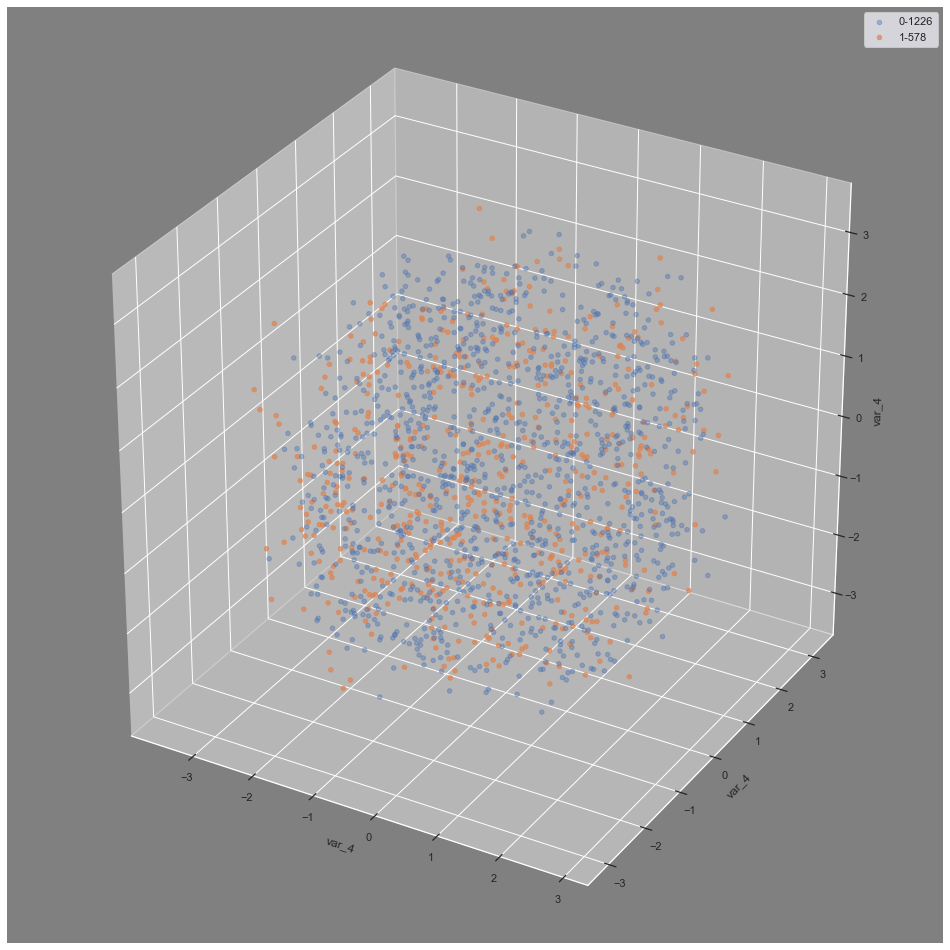

In [35]:
validation_set_pred = validation_dataset_section1_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

<b> Calibration

In [36]:
calibrated_knn = CalibratedClassifierCV(knneig, method='isotonic', cv=5)
calibrated_knn.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=4), cv=5,
                       method='isotonic')

In [37]:
knn_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_knn, X_train, Y_train, X_val, Y_val)

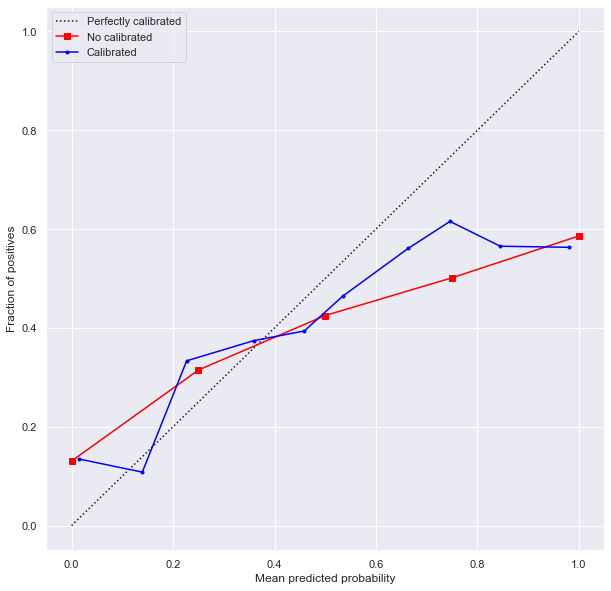

In [38]:
my_calibration_plot(model = knneig, calibrated_model = calibrated_knn, X_data = X_val, Y_data = Y_val)

### Random Forest

In [39]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=20,
                       n_estimators=550)

In [40]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [41]:
rf_metrics

{'Train': {'precision': 0.9748064475187207,
  'Accuracy': 0.9371751694316245,
  'AUC': 0.9862187756881005},
 'Validation': {'precision': 0.6637744034707158,
  'Accuracy': 0.7222838137472284,
  'AUC': 0.7646890443933196}}

In [42]:
conf_mat

Pred,0,1
True,,
0,997,155
1,346,306


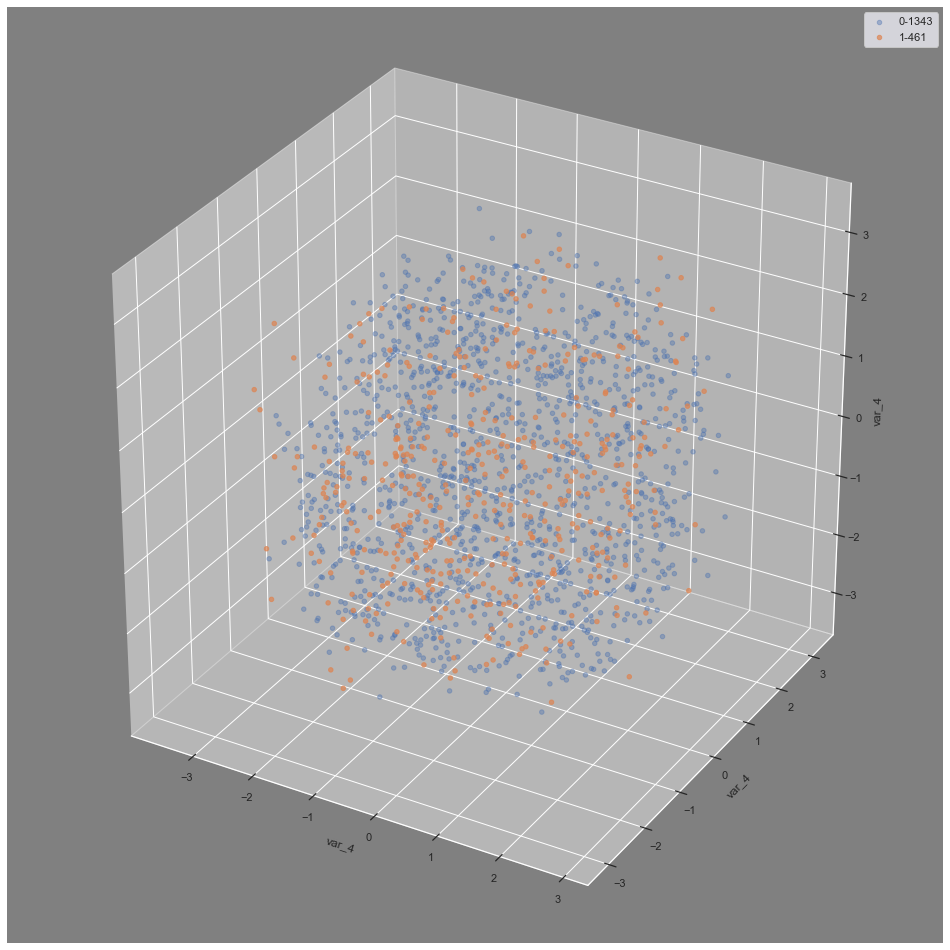

In [43]:
validation_set_pred = validation_dataset_section1_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

<b> Calibration

In [44]:
calibrated_rf = CalibratedClassifierCV(rfc, method='isotonic', cv=5)
calibrated_rf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=20,
                                                             min_samples_leaf=6,
                                                             min_samples_split=20,
                                                             n_estimators=550),
                       cv=5, method='isotonic')

In [45]:
rf_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_rf, X_train, Y_train, X_val, Y_val)

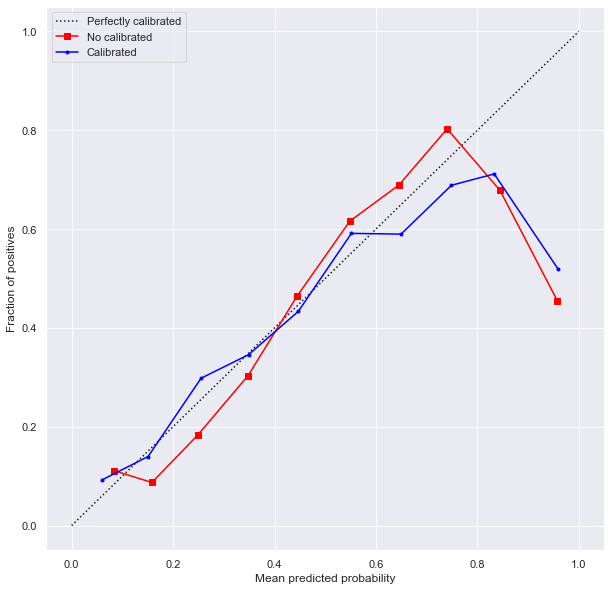

In [46]:
my_calibration_plot(model = rfc, calibrated_model = calibrated_rf, X_data = X_val, Y_data = Y_val)

<b> Summary

In [47]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.544898,0.662971,0.670706
KNN,0.532872,0.659645,0.691103
RF,0.663774,0.722284,0.764689


In [48]:
typex = 'Validation'
pd.DataFrame([svm_metrics_calib[typex],knn_metrics_calib[typex],rf_metrics_calib[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.55481,0.665743,0.672482
KNN,0.49931,0.638027,0.683342
RF,0.63447,0.717295,0.755537


## Section 2

In [12]:
train_section_2.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    56283
1     6773
Name: mahalanobis, dtype: int64

In [16]:
dict_1 = {'n':7600, 'range': [9,15], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':4000, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':9000, 'range': [9,15], 'label': 4, 'category': 2} # augmetation on the previous random ones

unscld_train_section_2 =unscaler(train_section_2, scalerx)
train_section_2_aug = augmentation_strategy(data = unscld_train_section_2, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_2
train_section_2_aug =  scaler(train_section_2_aug,scalerx)

In [17]:
train_section_2_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    56283
1     6773
2     7600
3     4000
4     9000
Name: mahalanobis, dtype: int64

### Common data to train and validation

In [18]:
seed = 158
validation_dataset_section2 = train_section_2_aug[train_section_2_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section2 = validation_dataset_section2.copy()
train_dataset_section2 = train_section_2_aug[~train_section_2_aug.index.isin(validation_dataset_section2.index)]

In [19]:
train_dataset_section2_aug = augmentation_selection_rates(train_dataset_section2, rate = 1.0, sample = 0.5)

In [20]:
len(train_dataset_section2_aug)  #30953

33946

In [21]:
X_train = train_dataset_section2_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section2_aug['target']

X_val = validation_dataset_section2[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section2['target']

#### Support Vector Machine

In [22]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.35, probability = True)
my_svm.fit(X_train, Y_train)

SVC(gamma=0.35, probability=True)

In [24]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [25]:
svm_metrics

{'Train': {'precision': 0.9989238311610666,
  'Accuracy': 0.8671124727508396,
  'AUC': 0.8594190660053824},
 'Validation': {'precision': 0.16666666666666666,
  'Accuracy': 0.892286221771124,
  'AUC': 0.5521531162839194}}

In [26]:
conf_mat

Pred,0,1
True,,
0,14064,10
1,1688,2


<b> Calibration

In [27]:
calibrated_svm = CalibratedClassifierCV(my_svm, method='isotonic', cv=5)
calibrated_svm.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=SVC(gamma=0.35, probability=True), cv=5,
                       method='isotonic')

In [28]:
svm_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_svm, X_train, Y_train, X_val, Y_val)

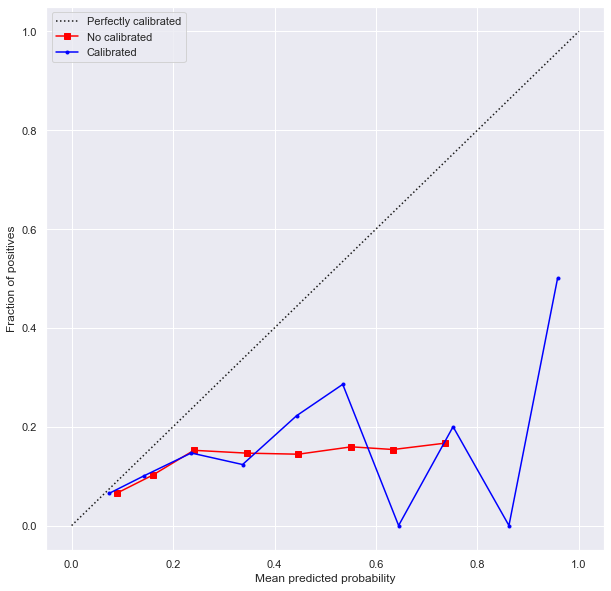

In [29]:
my_calibration_plot(model = my_svm, calibrated_model = calibrated_svm, X_data = X_val, Y_data = Y_val)

### KNN

In [30]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

In [31]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [32]:
knn_metrics

{'Train': {'precision': 0.9677316969953449,
  'Accuracy': 0.8817533730041831,
  'AUC': 0.9585045703024611},
 'Validation': {'precision': 0.2052469135802469,
  'Accuracy': 0.8685612788632326,
  'AUC': 0.6035754166691192}}

In [33]:
conf_mat

Pred,0,1
True,,
0,13559,515
1,1557,133


<b> Calibration

In [34]:
calibrated_knn = CalibratedClassifierCV(knneig, method='isotonic', cv=5)
calibrated_knn.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=4), cv=5,
                       method='isotonic')

In [35]:
knn_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_knn, X_train, Y_train, X_val, Y_val)

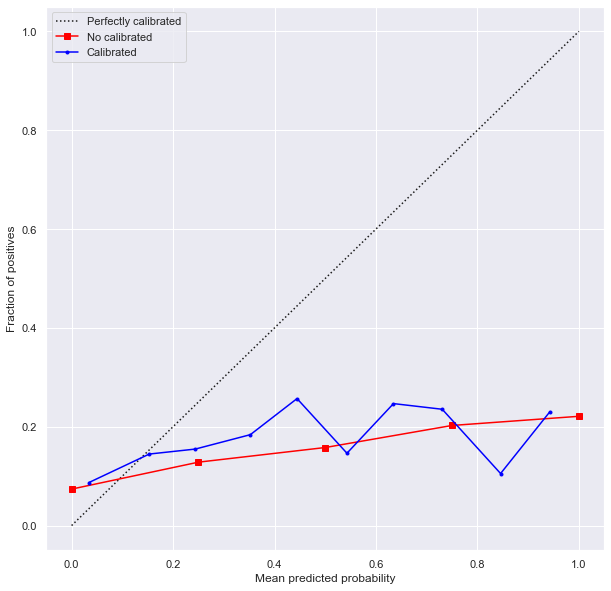

In [36]:
my_calibration_plot(model = knneig, calibrated_model = calibrated_knn, X_data = X_val, Y_data = Y_val)

### Random Forest

In [38]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=20,
                       n_estimators=550)

In [39]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [40]:
rf_metrics

{'Train': {'precision': 0.9997699827487061,
  'Accuracy': 0.8773051316797267,
  'AUC': 0.9850294084409632},
 'Validation': {'precision': 0.6842105263157895,
  'Accuracy': 0.8932377569144887,
  'AUC': 0.6704015041374712}}

In [41]:
conf_mat

Pred,0,1
True,,
0,14068,6
1,1677,13


<b> Calibration

In [42]:
calibrated_rf = CalibratedClassifierCV(rfc, method='isotonic', cv=5)
calibrated_rf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=20,
                                                             min_samples_leaf=6,
                                                             min_samples_split=20,
                                                             n_estimators=550),
                       cv=5, method='isotonic')

In [43]:
rf_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_rf, X_train, Y_train, X_val, Y_val)

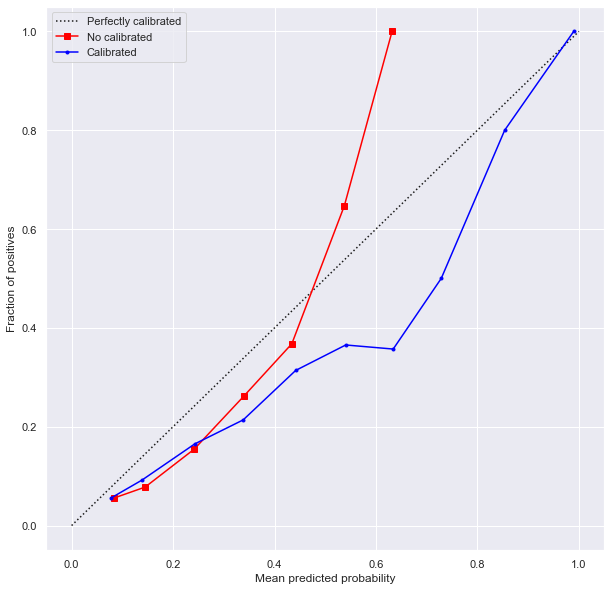

In [44]:
my_calibration_plot(model = rfc, calibrated_model = calibrated_rf, X_data = X_val, Y_data = Y_val)

<b> Summary

In [41]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.782235,0.880068,0.732848
KNN,0.275862,0.776062,0.632256
RF,0.454268,0.825290,0.720415


In [45]:
typex = 'Validation'
pd.DataFrame([svm_metrics_calib[typex],knn_metrics_calib[typex],rf_metrics_calib[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.173913,0.891842,0.556425
KNN,0.212230,0.882644,0.611888
RF,0.405063,0.890891,0.668965


## Section 3

In [54]:
train_section_3.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    61175
1     5267
Name: mahalanobis, dtype: int64

In [55]:
dict_1 = {'n':4600, 'range': [15,35], 'label': 2, 'rate': 0.65}
dict_2 = {'n':4800, 'label': 1}
dict_3 = {'n':3800, 'range': [15,35], 'label': 4, 'category': 2}

train_section_3_aug = augmentation_strategy(data = train_section_3, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features )


unscld_train_section_3 =unscaler(train_section_3, scalerx)
train_section_3_aug = augmentation_strategy(data = unscld_train_section_3, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_3
train_section_3_aug =  scaler(train_section_3_aug,scalerx)

In [56]:
train_section_3_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    61175
1     5267
2     4600
3     4800
4     3800
Name: mahalanobis, dtype: int64

### Common data to train and validation

In [57]:
seed = 158
validation_dataset_section3 = train_section_3_aug[train_section_3_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section3 = validation_dataset_section3.copy()
train_dataset_section3 = train_section_3_aug[~train_section_3_aug.index.isin(validation_dataset_section3.index)]

In [58]:
train_dataset_section3_aug = augmentation_selection_rates(train_dataset_section3, rate = 1.0, sample = 0.45)

In [59]:
len(train_dataset_section3_aug)

27689

In [60]:
X_train = train_dataset_section3_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section3_aug['target']

X_val = validation_dataset_section3[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section3['target']

#### Support Vector Machine

In [61]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.40, probability = True)
my_svm.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.4, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [62]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [63]:
svm_metrics

{'Train': {'precision': 1.0,
  'Accuracy': 0.8923760338040377,
  'AUC': 0.9950810478231684},
 'Validation': {'precision': 0.6153846153846154,
  'Accuracy': 0.9201685731487056,
  'AUC': 0.6586751000511564}}

In [64]:
conf_mat

Pred,0,1
True,,
0,15236,30
1,1296,48


### KNN

In [65]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [66]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [67]:
knn_metrics

{'Train': {'precision': 0.9468888888888889,
  'Accuracy': 0.8897034923615876,
  'AUC': 0.9504910776393751},
 'Validation': {'precision': 0.1586452762923351,
  'Accuracy': 0.8960264900662251,
  'AUC': 0.6233513589177319}}

In [68]:
conf_mat

Pred,0,1
True,,
0,14794,472
1,1255,89


### Random Forest

In [69]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [70]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [71]:
rf_metrics

{'Train': {'precision': 1.0,
  'Accuracy': 0.8739210516811731,
  'AUC': 0.983519040504084},
 'Validation': {'precision': 1.0,
  'Accuracy': 0.919626730885009,
  'AUC': 0.6786957614337494}}

In [72]:
conf_mat

Pred,0,1
True,,
0,15266.0,NaN
1,1335.0,9.0


<b> Summary

In [73]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.615385,0.920169,0.658675
KNN,0.158645,0.896026,0.623351
RF,1.000000,0.919627,0.678696


### Conclusions

* Limited or few number of variables improve computing power
* the data is splited in 3 parts thus attacking from less to most complex
* the tested models were SVM, KNN and RandomForest
* keep RF and SVM

* Section One:
    + fast execution time in general
    + it can be used the 100% of the data
* Section two:
    + fast execution time using some rate of the data
* section three:
    + low execution time , use high rate of the data or reduce dimmensionality
